# Project 242

## Import

In [140]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [142]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


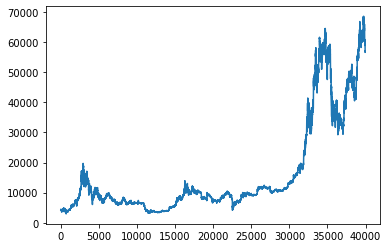

In [143]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [144]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})
data.columns

Index(['open', 'high', 'low', 'close', 'Volume'], dtype='object')

Here, we can decide to add features ...

In [145]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [146]:
data = data.drop(['VWAP'], axis = 1)

In [147]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 12) | X_test: (9978, 12)


In [148]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [149]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [150]:
# Add Signal
q_90 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.9)

train_data = add_signal(train_data, q_90)
test_data = add_signal(test_data, q_90)

In [151]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (5.0%) | 0 (90.0%) | -1 (5.0%)
Test set: 1 (6.0%) | 0 (88.0%) | -1 (6.0%)


In [152]:
#display(train_data.head(2))
#display(test_data.head(2))

In [177]:
train_data['Signal'].describe()

count    29936.000000
mean         0.000067
std          0.316254
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Signal, dtype: float64

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [153]:
X_train, y_train, return_train = prepare_data_for_training(train_data, lookback_period=10, signal = True)
X_test, y_test, return_test = prepare_data_for_training(test_data, lookback_period=10, signal = True)

y_train = y_train[10:]

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


In [154]:
## Remove empty lists in the beginning
while len(X_train[0]) == 0:
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) == 0:
    X_test = X_test[1:]
    y_test = y_test[1:]

In [155]:
from tqdm import tqdm
def format_2D(arr):
    res = []
    for item in arr:
        features = []
        for day in item:
            features += day.tolist()
        res.append(features)
    return res
X_train = format_2D(X_train)
X_test = format_2D(X_test)

In [156]:
## Some indicators have a larger lookback period than other. 
## We remove the beginning of the dataset to make everything homogeneous

while len(X_train[0]) != 10*len(data.columns):
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) != 10*len(data.columns):
    X_test = X_test[1:]
    y_test = y_test[1:]
    
X_train = np.array(X_train)
X_test = np.array(X_test)

### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [157]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [158]:
# ccp_alpha values
# grid_values = {'ccp_alpha': np.linspace(0, 0.001, 10)}

# Regression Tree
#dtc_cv = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=20, random_state=88)

# Regression Tree for all ccp_alpha
#dtc_cv = GridSearchCV(dtc, param_grid=grid_values, scoring='accuracy', cv=5, verbose=1)
#dtc_cv.fit(X_train, y_train)

In [159]:
## The goal here is to plot accuracy scores with respect to ccp_alpha, to justify my choice
#import matplotlib.pyplot as plt
#ccp_alpha = dtc_cv.cv_results_['param_ccp_alpha'].data
#R2_scores = dtc_cv.cv_results_['mean_test_score']

#plt.figure(figsize=(8, 6))
#plt.xlabel('ccp_alpha', fontsize=16)
#plt.ylabel('CV Accuracy', fontsize=16)
#plt.scatter(ccp_alpha, R2_scores, s=30)
#plt.plot(ccp_alpha, R2_scores, linewidth=3)
#plt.grid(True, which='both')

#plt.tight_layout()
#plt.show()

In [160]:
#print('Best ccp_alpha', dtc_cv.best_params_) #I select the alpha value with the highest accuracy
#print('Best Accuracy score', dtc_cv.best_score_)

In [161]:
features = []
for k in range(10):
    features = features + [col+": Day -"+str(10-k) for col in data.columns]

Node count: 5499


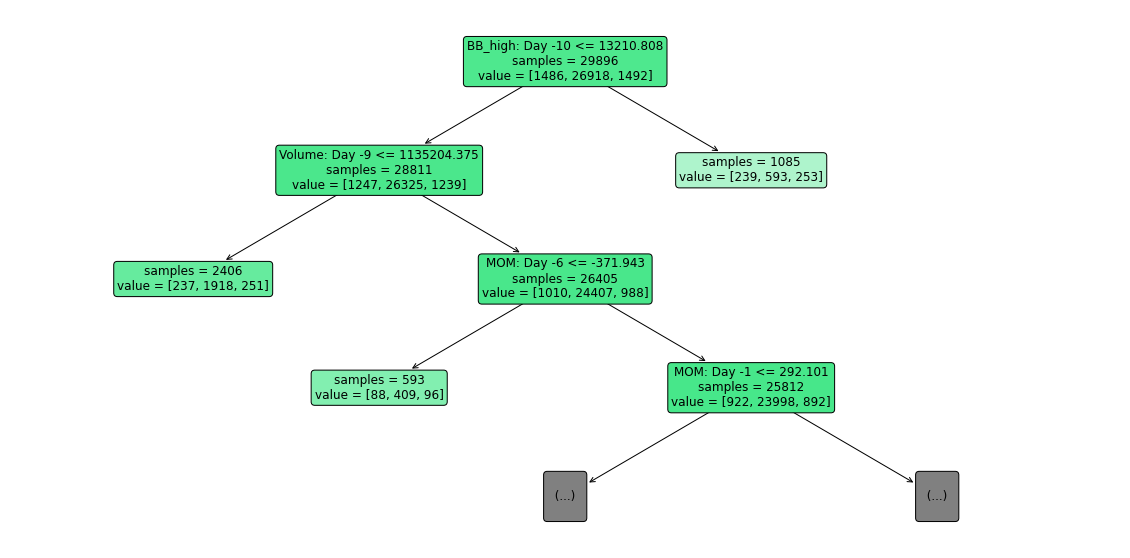

In [162]:
from sklearn.tree import plot_tree
print('Node count:', dtc.tree_.node_count)
plt.figure(figsize=(20,10))
plot_tree(dtc_cv.best_estimator_, feature_names=features,
        filled=True,impurity=False, rounded=True,fontsize=12,max_depth=3)
plt.show()

In [163]:
y_pred = dtc.predict(X_test)

### 3. Test prediction model

In [164]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [165]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Baseline,0,0,0.622693,0,0


### III. Strategy

### 1. Get data ready for backtesting

In [166]:
# If the model used is a regression model on the return
#signal = get_signal(y_pred, alpha=q_90)

In [167]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

count    9968.000000
mean       -0.033407
std         0.553714
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64

In [168]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [169]:
strat = Strategy(cash=500, fees=0.001)

In [170]:
strat.run(signal_crop, close_crop, verbose=False)

In [171]:
wallet = np.array(strat.wallet)
profit = wallet[:-1] - wallet[1:]

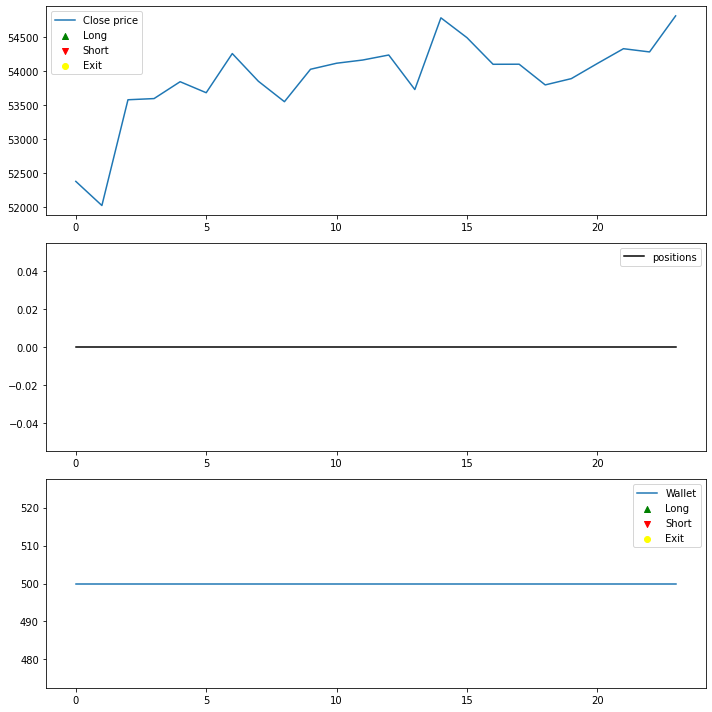

In [172]:
strat.visualize()

### 3. Test performance startegy

In [173]:
SharpeRatio = SharpeRatio(profit)
MaxDrawback = MaxDrawback(profit)
WinLossRatio = WinLossRatio(profit)
CumulativeProfit = CumulativeProfit(profit)
MeanProfit = MeanProfit(profit)

/Users/noemielevy/INDENG-242-project/modules/metrics_performance.py:26: RuntimeWarning: invalid value encountered in double_scalars
  return mean_profit/var_profit
/Users/noemielevy/INDENG-242-project/modules/metrics_performance.py:37: RuntimeWarning: invalid value encountered in long_scalars
  return win/loss


In [174]:
models = ['Baseline']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[SharpeRatio, MaxDrawback, WinLossRatio, CumulativeProfit, MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
Baseline,NaN,0.0,NaN,0.0,0.0
